# Natural Language Processing with Python

Natural language processing - commonly referred to as NLP - is the area of computer science dedicated to computers understanding human language such as speech or text. There are many examples of NLP applications including the following:

- Sentiment Analysis - Determine the tone of text
- Speech Recognition - Translate a sound clip to text
- Predictive Text - Complete sentences based on a few words

In this course, we will walk through the basics of NLP with Python libraries such as pandas, spaCy, and scikit-learn. We will cover the following topics:
- Preprocessing
- Token Frequency
- Part of Speech Tagging
- Named Entity Recognition
- Text Similarity
- Dependency Parsing

This course assumes you have a beginner to intermediate knowledge of Python.

## Downloading PyCharm
We will use PyCharm as the primary integrated development environment for this tutorial, but feel free to use your own IDE. To install Pycharm, select the Community Edition from [this link](https://www.jetbrains.com/pycharm/download/) (it's free!).

## spaCy
Throughout this tutorial, we will be using a spaCy, a popular open-source library for NLP in Python. The library is designed to help you create applications that process and understand text. spaCy offers several pre-made text processing pipelines on their site. The pipelines are packaged as [models](https://spacy.io/models/en) which can be downloaded. For this demo, we will download the small English model trained on text from blogs, news, and comments.

In [1]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 10.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import spacy
from spacy import displacy
import string
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from pathlib import Path
nlp = spacy.load('en_core_web_sm')


## The Data
In this course, we will analyze a sample of 500 Amazon Home and Kitchen product reviews. [The data](http://jmcauley.ucsd.edu/data/amazon/links.html) is provided by Julian McAuley at the University of California, San Diego and contains reviews from May 1996 - July 2014. In addition to reviews (ratings, text, helpfulness votes), McAuley provides product metadata (descriptions, category information, price, brand, and image features) and links (also viewed/also bought graphs). 

For this course, we will focus on the review data only. This data is a great example of the ways humans typically communicate through text and includes reviews with typos, run on sentences, and grammatical errors.

McAuley provides the following functions to parse the JSON dataset and save it as a dataframe.

In [3]:
def parse(path):
    f = open(path, 'rb')
    for l in f:
        yield eval(l)


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
df = getDF('Home_and_Kitchen_5.json')
df_sample = df.sample(n=500, random_state=1)

In [6]:
df_sample.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
338364,A3SU2IZMOTDPGI,B002YK4ESI,irishyank,"[1, 5]",I opened the box and to my surprise the scoop ...,1.0,Failed me,1294876800,"01 13, 2011"
267506,A1TRKTTP1NM71H,B001FB6IFY,"Dr. Dave ""-- Fair and Balanced Reviews""","[1, 6]",I purchased this thermometer because a friend ...,5.0,Great Thermometer - Disappointing Weekend,1358985600,"01 24, 2013"
428410,A2A4C5N5B47Z0Q,B0051AQXZK,Paula Philbrick,"[0, 0]","The mattress was custom for my daughter, and s...",5.0,Hard to Get Out of Bed,1375660800,"08 5, 2013"
262480,ANVISS3NQQBFD,B001E5CWVU,A. J. Marshall,"[3, 3]","This is entirely my own fault, but hopefully p...",4.0,Too small for a lot of recipes,1372118400,"06 25, 2013"
241188,A2LQ1O3IHJQPFF,B00179D7IK,Meredith,"[0, 0]","My long-time teapot recently broke, so I decid...",4.0,Cute teapot,1368057600,"05 9, 2013"


## Text Preprocessing
Text preprocessing applies a variety of steps to text in order to clean or transform it for the computer to better understand. There are several common preprocessing steps. Let's take an example sentence and apply these steps to it.

Sentence: "She was offered the job 11 months ago."

- Lowercase 
    - "she was offered the job 11 months ago."
- Remove punctuation 
    - "she was offered the job 11 months ago"
- Remove numbers 
    - "she was offered the job months ago"
- Remove stop words - remove words that are very common in the English language 
    - "she offered job months ago"
- Tokenization - splitting the sentence up into tokens 
    - "she", "offered", "job", "months", "ago"
- Stemming / lemmatization - transforming the token into its root form 
    - "offer", "job", "month", "ago"

While these are all very popular preprocessing steps, they may not all be used on every project or even in this same order. The data you have and the problem you're trying to solve may add or remove any of these steps (and more) from your preprocessing. For example, if you want to see how many sentences are in the average Amazon review, you shouldn't remove punctuation.

spaCy allows us to apply all of the preprocessing steps above in a single line of code by using [token attributes](https://spacy.io/api/token#attributes).
- `token.lemma_` - lemmatizes the token
- `token.is_alpha` - Removes punctuation and numbers (non-alphabetic characters)
- `token.is_stop` - Removes stop words

In [7]:
# Try out text preprocessing on sample text
text = "She was offered the job 11 months ago."
doc = nlp(text)
text_clean = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

In [8]:
print(doc)

She was offered the job 11 months ago.


In [9]:
print(text_clean)

['offer', 'job', 'month', 'ago']


In [10]:
# Preprocess the entire dataframe
def preprocess_text(spacy_doc: spacy.tokens.doc.Doc) -> str:
    """
    Preprocess a spacy Doc by lemmatizing, removing stop words, and removing non-alphabetical characters.
    
    Parameters
    ----------
    spacy_doc: spacy.tokens.doc.Doc
        A spacy Doc object, i.e. a sequence of Token objects

    Returns
    -------
    str
        The cleaned text

    """
    text_clean = [token.lemma_ for token in spacy_doc if token.is_alpha and not token.is_stop]
    return ' '.join(text_clean)


df_sample['spacy_doc'] = df_sample['reviewText'].apply(lambda x: nlp(x))
df_sample['review_text_clean'] = df_sample['spacy_doc'].apply(lambda x: preprocess_text(x))

In [11]:
print(df_sample['spacy_doc'].head())

338364    (I, opened, the, box, and, to, my, surprise, t...
267506    (I, purchased, this, thermometer, because, a, ...
428410    (The, mattress, was, custom, for, my, daughter...
262480    (This, is, entirely, my, own, fault, ,, but, h...
241188    (My, long, -, time, teapot, recently, broke, ,...
Name: spacy_doc, dtype: object


In [12]:
print(df_sample['review_text_clean'].head())

338364             open box surprise scoop handle send asap
267506    purchase thermometer friend visit weekend say ...
428410    mattress custom daughter miss away amazingly s...
262480    entirely fault hopefully point help thinking b...
241188    long time teapot recently break decide purchas...
Name: review_text_clean, dtype: object


## Term Frequency
With thousands of data points, we don't have time to read through each individual review to learn more about the data set. One way we can summarize the data is through the most popular words in reviews (term frequency). To do this, we use `CountVectorizer` from `scikit-learn`.

CountVectorizer converts text into a matrix of token counts. It has a variety of [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) you can use to customize your results, but we will focus on `stop_words` and `ngram_range`.

Although we previously removed stop words in our preprocessing steps, scikit-learn uses a different set of stop words than spaCy. Oftentimes it is beneficial to combine multiple stop words lists or create your own custom list to exclude common words that don't add value.

N-grams are used to break text up into chunks. An example of a 1-gram is "hello", and an example of a 2-gram is "hello there". Modifying the `ngram_range` in `CountVectorizer` allows us to see the most popular words AND most popular phrases.

In [14]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))
docs = vectorizer.fit_transform(df_sample['review_text_clean'])
features = vectorizer.get_feature_names_out()

Next, we plot the most popular words with `FreqDistVisualizer` from `scikit-yellowbrick`.

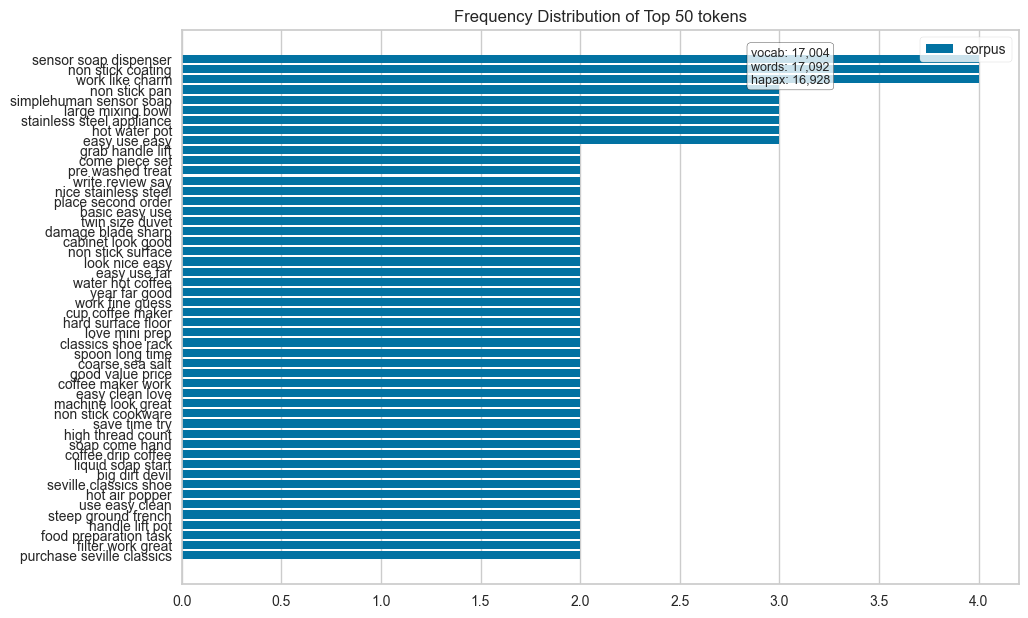

<AxesSubplot: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [15]:
visualizer = FreqDistVisualizer(features=features, size=(1080, 720))
visualizer.fit(docs)
visualizer.show()

In [16]:
df_sample['token_count_all'] = df_sample['spacy_doc'].apply(lambda x: len(x))
df_sample['token_count_clean'] = df_sample['review_text_clean'].apply(lambda x: len(x.split()))

<AxesSubplot: title={'center': 'All Tokens per Review'}, xlabel='Tokens', ylabel='Number of Reviews'>

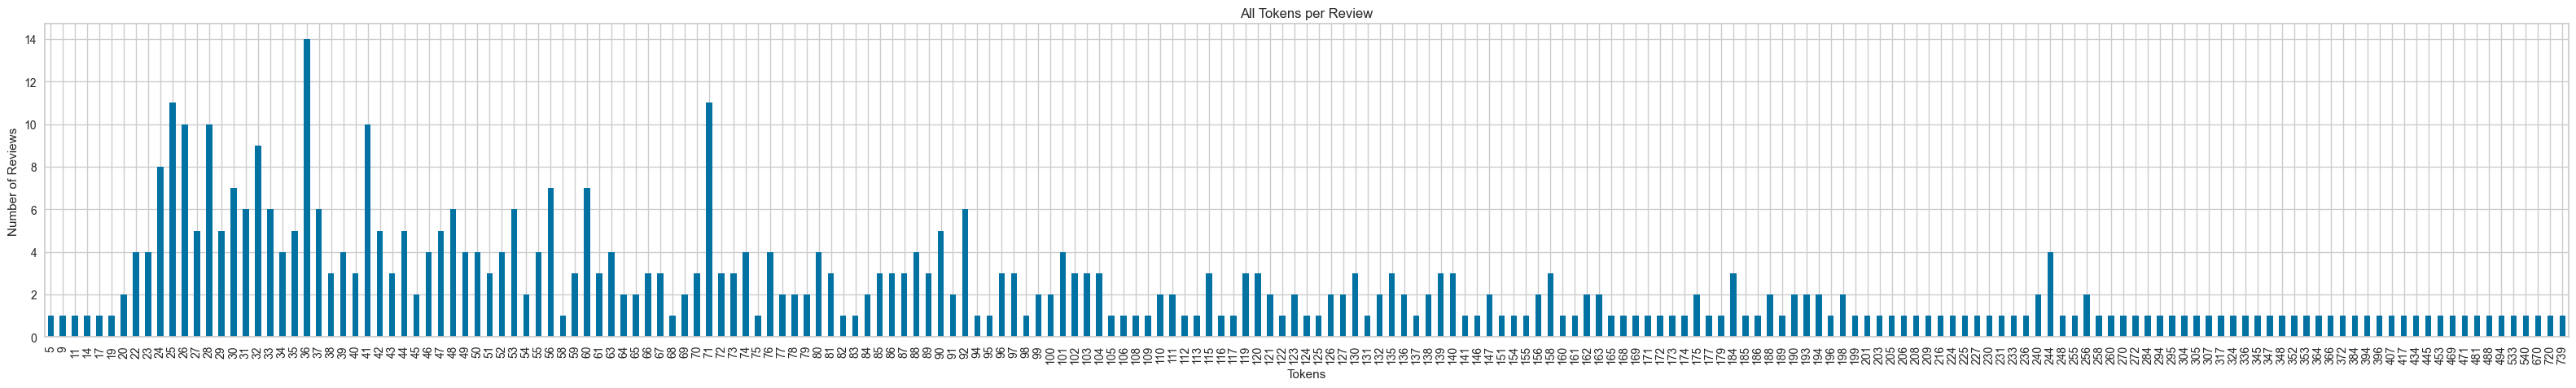

In [17]:
df_sample['token_count_all'].value_counts().sort_index().plot.bar(figsize=(40,5), 
                                                                    title='All Tokens per Review',
                                                                    xlabel='Tokens',
                                                                    ylabel='Number of Reviews')

<AxesSubplot: title={'center': 'Clean Tokens per Review'}, xlabel='Tokens', ylabel='Number of Reviews'>

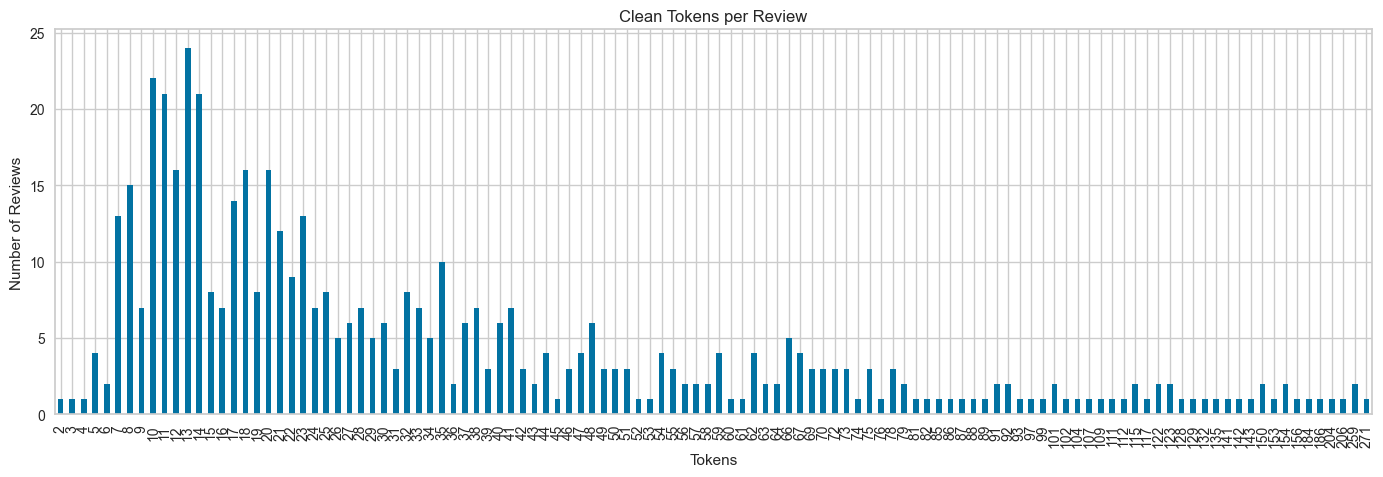

In [18]:
df_sample['token_count_clean'].value_counts().sort_index().plot.bar(figsize=(17,5), 
                                                                    title='Clean Tokens per Review',
                                                                    xlabel='Tokens',
                                                                    ylabel='Number of Reviews')

In [19]:
df_sample[df_sample['token_count_clean'] == 271]['reviewText'].values[0]

'This is my first burr grinder and I had high hopes. I used it a couple of times this morning for the first time. Like others said, I don\'t think the coarse grind (when set to the unit\'s little French press symbol) makes large enough particles for a French press. But that\'s fairly minor. The lid to the top bean loader compartment is really dorky and awkward to use. A fixed, hinged lid would have been better.Bodum says you can store a week\'s worth of beans into this, but the unit\'s not airtight so I\'m not doing that and then taste my coffee get more stale each day. Before this, I\'d  only ever used a blade grinder. To me, the coffee from the Bodum tasted more bitter, but I\'m just starting out with it and maybe need to ride the learning curve.Overall, the whole unit feels cheap. The plastic bean loader/grind adjuster moves around a lot as you adjust it and the unit itself is very light in weight.The 20 second timer engine burnout factor shows extremely poor design. If the engine i

## Named Entity Recognition
Named Entity Recognition (NER) identifies real-world objects such as people, places, or things in text. NER is useful in many scenarios such as identifying and masking sensitive information such as names of people. spaCy recognizes [several different types of entities](https://v2.spacy.io/api/annotation#named-entities) and has a nice visualization to highlight all entities it recognized in text. 

In [20]:
doc = df_sample['spacy_doc'][271416]
print(doc)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

These things are a bit difficult to get use to when gripping things. I found that I could not remove my Lodge cast iron skillet from the oven using one of these, it took two. I much prefer my Farberware Pro Silicone Grabbers. You can get them here at Amazon. Gripping the skillet handle with the OXO puts the cloth part in contact with the pan, and on a gas stove, the flame, so that is out. I can see how keeping your thumb out of the holder would improve your grip, but who wants to keep their hand out of the holder reaching into a 400 degree oven? The Silicone Grabbers are a much better tool for my needs.
Lodge 104 109 ORG
two 170 173 CARDINAL
Farberware Pro Silicone Grabbers 192 224 PERSON
Amazon 251 257 ORG
OXO 296 299 GPE
400 degree 535 545 QUANTITY
The Silicone Grabbers 552 573 WORK_OF_ART


In [21]:
displacy.render(df_sample['spacy_doc'][271416], style="ent")

In [22]:
# Recognize all entities in all Amazon reviews
df_entities = pd.DataFrame(columns=['index', 'spacy_doc', 'entity_text', 'entity_label', 'entity_start', 'entity_end'])

index = 0
for row in df_sample.itertuples():
    for ent in row.spacy_doc.ents:
        df_entities.at[index, 'index'] = row.Index
        df_entities.at[index, 'spacy_doc'] = row.spacy_doc
        df_entities.at[index, 'entity_text'] = ent.text
        df_entities.at[index, 'entity_label'] = ent.label_
        df_entities.at[index, 'entity_start'] = ent.start_char
        df_entities.at[index, 'entity_end'] = ent.end_char
        index += 1

In [23]:
df_entities.head()

,index,spacy_doc,entity_text,entity_label,entity_start,entity_end
0,267506,"(I, purchased, this, thermometer, because, a, ...",the weekend,DATE,71,82
1,267506,"(I, purchased, this, thermometer, because, a, ...",212,CARDINAL,306,309
2,267506,"(I, purchased, this, thermometer, because, a, ...",39F.,CARDINAL,357,361
3,267506,"(I, purchased, this, thermometer, because, a, ...",the weekend,DATE,398,409
4,267506,"(I, purchased, this, thermometer, because, a, ...",one,CARDINAL,490,493


In [24]:
#See the most popular entities recognized
df_entities['entity_label'].value_counts()

CARDINAL       387
DATE           199
ORG            194
PERSON         117
ORDINAL         92
TIME            68
GPE             63
MONEY           60
NORP            48
QUANTITY        40
WORK_OF_ART     19
PRODUCT         13
PERCENT         10
LOC              7
FAC              6
LANGUAGE         2
LAW              2
Name: entity_label, dtype: int64

In [48]:
#See what products are recognized
df_filtered = df_entities[df_entities['entity_label'] == 'ORG'] # entity_label = ORG, PRODUCT, PERSON, WORK_OF_ART

In [49]:
df_filtered['entity_text'].value_counts()

Amazon                  25
Lodge                    6
Teflon                   4
Amazon.com               4
WindTunnel               3
                        ..
THE EGG SHAPE NOWBUT     1
APPLE                    1
Clip Stick               1
Norelco                  1
Walmart                  1
Name: entity_text, Length: 141, dtype: int64

## Part of Speech Tagging
Part-of-Speech tagging determines which [part of speech](https://en.wikipedia.org/wiki/Part_of_speech) each token is. This usually occurs behind the scenes before lemmatization since many words can serve as multiple parts of speech and may be lemmatized differently depending on the certain part of speech. Additionally, POS tagging is used as a foundation for NER and many other text processing steps. One real world application of POS tagging is to distinguish between words with the same spelling but different meanings for translation. For example, if a computer was translating "Can you throw this can in the trash?" to Spanish, it would need to know that "can" has two different parts of speech in this sentence.

In [27]:
doc = df_sample['spacy_doc'][271416]
for token in doc:
    print(token.text, token.pos_, token.dep_)

These DET det
things NOUN nsubj
are AUX ROOT
a DET det
bit NOUN npadvmod
difficult ADJ acomp
to PART aux
get VERB xcomp
use NOUN dobj
to ADP prep
when SCONJ advmod
gripping VERB pcomp
things NOUN dobj
. PUNCT punct
I PRON nsubj
found VERB ccomp
that SCONJ mark
I PRON nsubj
could AUX aux
not PART neg
remove VERB ccomp
my PRON poss
Lodge PROPN dobj
cast NOUN dobj
iron NOUN compound
skillet NOUN dobj
from ADP prep
the DET det
oven NOUN pobj
using VERB advcl
one NUM dobj
of ADP prep
these PRON pobj
, PUNCT punct
it PRON nsubj
took VERB ROOT
two NUM dobj
. PUNCT punct
I PRON nsubj
much ADV advmod
prefer VERB ROOT
my PRON poss
Farberware PROPN compound
Pro PROPN compound
Silicone PROPN compound
Grabbers PROPN dobj
. PUNCT punct
You PRON nsubj
can AUX aux
get VERB ROOT
them PRON dobj
here ADV advmod
at ADP prep
Amazon PROPN pobj
. PUNCT punct
Gripping VERB csubj
the DET det
skillet NOUN dobj
handle VERB ROOT
with ADP prep
the DET det
OXO PROPN pobj
puts VERB conj
the DET det
cloth NOUN compou

In [28]:
# Dependency Parsing

displacy.render(df_sample['spacy_doc'][271416], style="dep")

In [29]:
doc = df_sample['spacy_doc'][271416]

In [30]:
for token in doc:
    if token.pos_ == 'ADJ' or token.pos_ == 'ADV':
        print(token.text, token.pos_, token.dep_)

difficult ADJ acomp
much ADV advmod
here ADV advmod
out ADV advmod
oven ADJ amod
much ADV advmod
better ADJ amod


In [31]:
def count_adverbs_adjectives(spacy_doc: spacy.tokens.doc.Doc) -> int:
    """
    Count the number of adjectives and adverbs in the text
    
    Parameters
    ----------
    spacy_doc: spacy.tokens.doc.Doc
        A spacy Doc object, i.e. a sequence of Token objects

    Returns
    -------
    int
        The number of adverbs and adjectives in the text

    """
    counter = 0
    for token in spacy_doc:
        if token.pos_ == 'ADJ' or token.pos_ == 'ADV':
            counter+=1
    
    return counter   

In [32]:
df_sample['count_adj_adv'] = df_sample['spacy_doc'].apply(lambda x: count_adverbs_adjectives(x))

<AxesSubplot: >

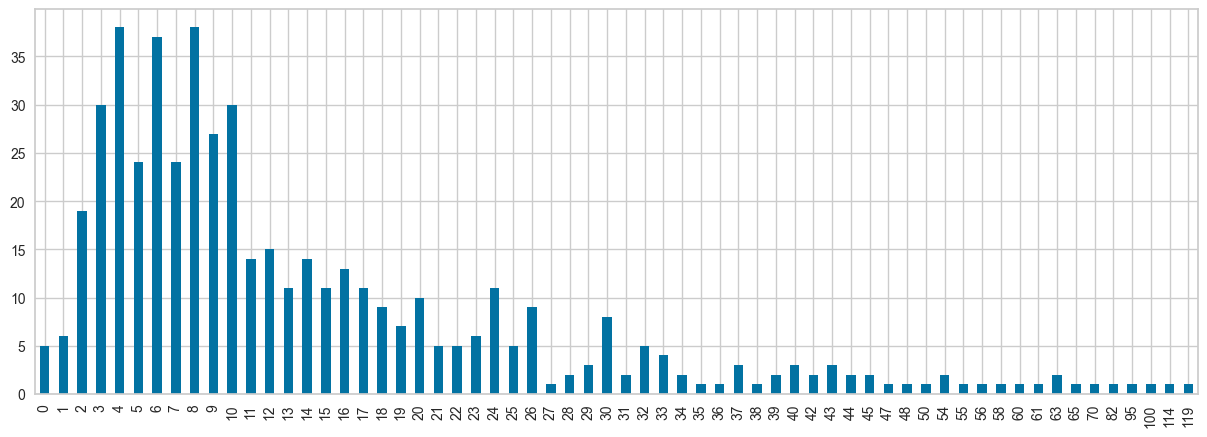

In [33]:
df_sample['count_adj_adv'].value_counts().sort_index().plot.bar(figsize=(15,5))

In [41]:
df_sample[df_sample['count_adj_adv'] == 119]['reviewText'].values[0]

'I just received my NE-1054F and I\'m immediately very happy with it. The background on this purchase is that I have owned two Panasonic "inverter" microwaves and I have really liked the powerful magnetron but the push button door opening mechanisms were flawed and more significantly, they both broke after a couple of years. (See my other reviews!).  I loved the inverter technology (soften cold butter without melting it anyone?) I was about to abandon the brand but I saw this model in my office pantry and was intrigued.Differences from a consumer model:Door. It has a great (yes plastic) handle instead of that square push button on consumer models which gradually got harder to push, sliding the microwave back against the wall in the process, before it broke completely on my first model.Weight.  At 34lbs, it must be 3 times heavier than the old one and I assume it is due to heavier magnets and more metal in the heart of the thing.Controls. There are 10 preset buttons for 10, 20,30,45,60 